In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import time
import PIL
import imageio

from IPython import display

import tensorflow as tf
from tensorflow.keras import datasets, layers, Sequential, Model
from tensorflow.keras import metrics
from tensorflow.keras import constraints

tf.__version__

'2.6.0'

In [2]:
import sys 
sys.path.append("../") 

from load_data import load_blobs, get_bootstrap_bags
from model import BlobsGAN
from train import train
from util import plot_and_save_fig, create_dir, generated_gif


In [3]:
# Set environment variables
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Data

In [4]:
random_state = 2
num_disc = 5
train_size = 10000

In [5]:
# load noisy_circles
(train_dataset, train_labels, train_density), (test_dataset, test_labels, test_density) \
    = load_blobs('dataset/gmm_9blobs.pkl', train_size)

train_dataset.shape, test_dataset.shape

((10000, 2), (50000, 2))

In [6]:
if num_disc==1:
    bootstrap_bags = train_dataset.reshape(1, train_size, 2)
    indices = np.asarray(range(0, len(train_dataset))).reshape(1, len(train_dataset))
else:
    indices, bootstrap_bags = get_bootstrap_bags(
        train_dataset, num_disc, random_state=random_state
    )
    
bootstrap_bags.shape

(5, 10000, 2)

In [7]:
#out of bags
oob_indices = [list(set(range(train_dataset.shape[0])) - set(indices[x])) for x in range(num_disc)]
len(oob_indices[0]) # about 1/3 samples unused

3619

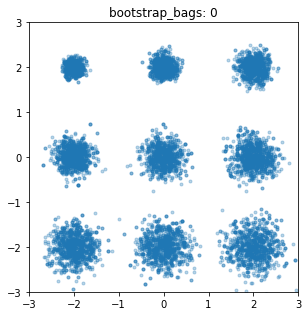

In [8]:
plot_and_save_fig(bootstrap_bags[0], "bootstrap_bags: 0")

# Build GAN

In [9]:
noise_dim = 20
lr = 1e-5
layers_ = [1, 1, 1, 1] # generate; discriminator

blobs_model = BlobsGAN(noise_dim, num_disc, lr, layers=layers_)

2022-12-09 14:34:55.752400: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 14:34:56.627331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 75025 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:13:00.0, compute capability: 8.0


## Generator

In [10]:
generator = blobs_model.generator
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               5376      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 71,682
Trainable params: 71,682
Non-trainable params: 0
_________________________________________________________________


## Discriminator

In [11]:
# Use the (as yet untrained) discriminator 
# to classify the generated images as real or fake.
discriminators = blobs_model.discriminators
discriminators[0].summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               768       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 66,817
Trainable params: 66,817
Non-trainable params: 0
_________________________________________________________________


# Training

In [12]:
model_dir = './training_checkpoints/GAN_control_parameter/num_disc_{}-{}-{}-{}-{}'.format(num_disc, layers_[0], layers_[1], layers_[2], layers_[3])

checkpoint_dir = os.path.join(model_dir, 'check_points')
fig_dir = os.path.join(model_dir, 'epoch_figs')
loss_log = model_dir + "/loss_log.txt"

create_dir(fig_dir)
create_dir(checkpoint_dir)

checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminators=discriminators)

creat a new dir: ./training_checkpoints/GAN_control_parameter/num_disc_5-1-1-1-1/epoch_figs
creat a new dir: ./training_checkpoints/GAN_control_parameter/num_disc_5-1-1-1-1/check_points


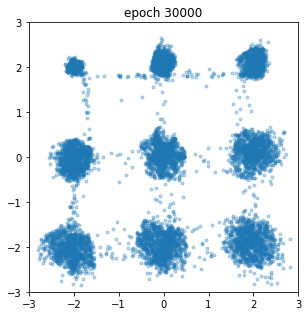

epoch-29999; 0.71099	1.37762	1.37890	1.37685	1.37809	1.37809	; tmes:1.3714s


In [13]:
epochs = 5000
batch_size = 128
gen_loss_log, disc_loss_log = train(
    model=          blobs_model,
    bootstrap_bags= bootstrap_bags,
    epochs=         epochs,
    batch_size=     batch_size,
    fig_dir=        fig_dir,
    checkpoint=     checkpoint,
    checkpoint_dir= checkpoint_dir,
    iteration_D=    2,
    loss_log=       loss_log,
    penalty=        False,
)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

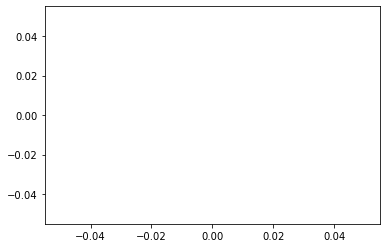

In [14]:
# loss curve
# generator
plt.plot(range(len(gen_loss_log)), gen_loss_log, 'r', label='G')

# discriminator
disc_loss_array = np.asarray(disc_loss_log)
for i in range(num_disc):
    plt.plot(range(disc_loss_array.shape[0]), disc_loss_array[:,i], label='$D_{}$'.format(i+1))

plt.legend()

plt.savefig(os.path.join(model_dir, 'loss_curve.svg'), transparent=True, bbox_inches='tight')

plt.show()

In [ ]:
generated_gif(fig_dir, os.path.join(model_dir, 'anim.gif'))

![SegmentLocal](training_checkpoints/GAN/num_disc_5/anim.gif)

# 2D wassertain distance

In [ ]:
# load checkpoint
storing_point = tf.train.latest_checkpoint(checkpoint_dir)
# storing_point = './training_checkpoints/PAR-DCGAN-1000-Disc-2/1-1-avg-1'
print(storing_point)
checkpoint.restore(storing_point)

In [ ]:
seed = tf.random.normal([1000, blobs_model.noise_dim])
generated_points = blobs_model.generator(seed, training=False)

In [ ]:
epoch=4999
plot_and_save_fig(generated_points, 'epoch {}'.format(epoch + 1),
                  os.path.join(fig_dir, 'epoch{}.svg'.format(epoch + 1)))

In [ ]:
generated_Z = contour_height(generated_points, 5, 1.2)

In [ ]:
plt.imshow(generated_Z)

In [ ]:
plt.contour(generated_Z)

In [ ]:
train_Z = contour_height(train_dataset, 5, 1.2)

In [ ]:
plt.imshow(train_Z)

In [ ]:
plt.contour(train_Z)

In [ ]:
(generated_Z-train_Z).sum()

In [ ]:
plt.imshow(generated_Z-train_Z)